In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import torch
from torch.autograd import Variable

In [12]:
# 데이터 로딩
train_X_data = pd.read_csv('./train_set/train_X_data.csv', index_col='datetime', parse_dates=True)
test_X_data = pd.read_csv('./test_set/test_X_data.csv', index_col='datetime', parse_dates=True)
train_Y_data = pd.read_csv('./train_set/train_Y_data.csv', index_col='datetime', parse_dates=True)
test_Y_data = pd.read_csv('./test_set/test_Y_data.csv', index_col='datetime', parse_dates=True)


# X 데이터의 모든 열을 숫자형으로 변환
# apply(pd.to_numeric, errors='coerce')를 사용하면 변환되지 않는 값이 NaN으로 변환
train_X_data = train_X_data.apply(pd.to_numeric, errors='coerce') 
test_X_data = test_X_data.apply(pd.to_numeric, errors='coerce')

# 타겟 변수의 'Kp' 열을 숫자형으로 변환
train_Y_data['Kp'] = pd.to_numeric(train_Y_data['Kp'], errors='coerce')
test_Y_data['Kp'] = pd.to_numeric(test_Y_data['Kp'], errors='coerce')

# print(train_X_data.head)
# print(train_Y_data.head)

In [ ]:
# 데이터 스케일링
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# 훈련 데이터에 대해 스케일러 학습 및 변환
train_X_scaled = scaler_X.fit_transform(train_X_data)
train_Y_scaled = scaler_Y.fit_transform(train_Y_data)

# 테스트 데이터에 대해 스케일러 변환
test_X_scaled = scaler_X.transform(test_X_data)
test_Y_scaled = scaler_Y.transform(test_Y_data)

Test RMSE: 0.8355362593952385
test WRMSE : tensor(0.9363)


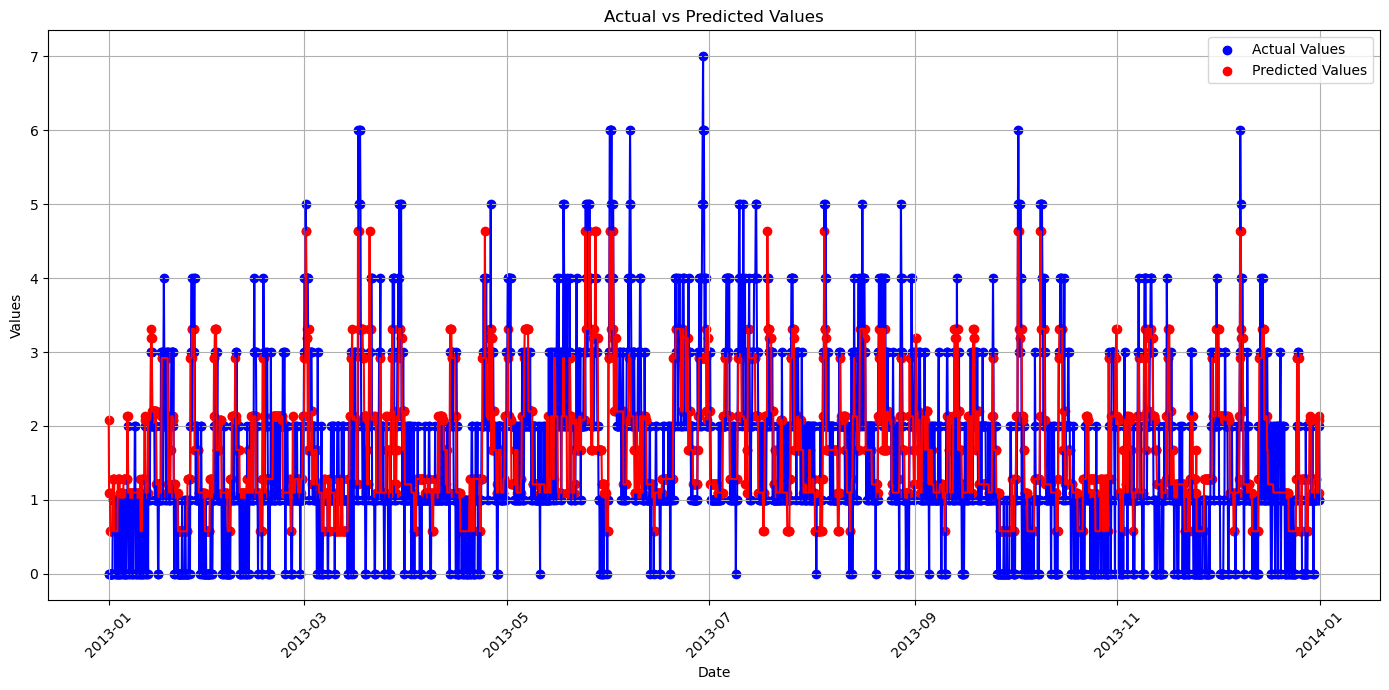

In [14]:
# GaussianHMM 모델 초기화
n_components = 12  # 사용할 상태의 수
hmm_model = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=1500, random_state=42)

# HMM은 시계열 데이터를 다루므로, X와 Y 데이터를 결합하여 학습
train_data = np.column_stack([train_X_data, train_Y_data['Kp']])
hmm_model.fit(train_data)

# 예측 수행
def hmm_predict(model, X):
    # 이전 상태를 기반으로 현재 관측값을 예측
    """
    HMM 모델을 사용하여 상태를 예측하고, 예측된 상태에 해당하는 평균 값을 반환.
    
    :param model: 학습된 HMM 모델
    :param X: 예측에 사용할 데이터
    :return: 예측된 값의 배열
    """
    predicted_states = model.predict(X)
    predicted_means = model.means_[predicted_states]
    return predicted_means[:, -1]

# 테스트 데이터 예측
test_data = np.column_stack([test_X_data, np.zeros(test_X_data.shape[0])])  # 더미 열 추가
y_pred = hmm_predict(hmm_model, test_data)

# 모델 성능 평가
test_rmse = np.sqrt(mean_squared_error(test_Y_data['Kp'], y_pred))
test_weights = pd.Series(np.ones(len(test_Y_data)), index=test_Y_data.index)


print(f'Test RMSE: {test_rmse}')
print("test WRMSE :",WRMSE(torch.tensor(y_pred).float(),torch.tensor(list(test_Y_data['Kp'])).float()))

# 예측 결과와 실제 값 시각화
plt.figure(figsize=(14, 7))

# 실제값과 예측값의 비교를 위해 test_Y_data를 NumPy 배열로 변환
y_actual = test_Y_data['Kp'].values.ravel()

# 그래프 그리기
plt.scatter(test_Y_data.index, y_actual, color='blue', label='Actual Values')
plt.scatter(test_Y_data.index, y_pred, color='red', label='Predicted Values')
plt.plot(test_Y_data.index, y_actual, color='blue') 
plt.plot(test_Y_data.index, y_pred, color='red')   
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.tight_layout()       # 레이아웃 조정
plt.show()

# 예측 결과를 데이터프레임으로 변환
#results = pd.DataFrame({'datetime': test_Y_data.index, 'Predicted': y_pred})

# 결과를 CSV 파일로 저장
#results.set_index('datetime', inplace=True)
#results.to_csv('./HMM_Performance.csv')

# 저장된 결과의 상위 5개 행 출력
#print(results.head())